## load data

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!






/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x+1) / 2
    # clamp func is to restrict range of value
    return out.clamp(0,1)

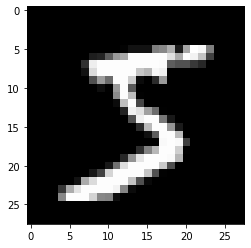

In [4]:
import matplotlib.pyplot as plt

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')

In [5]:
from torch.utils.data import  DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first
torch.Size([100, 1, 28, 28])


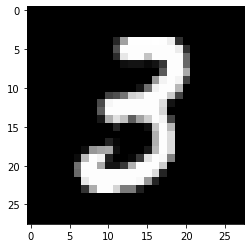

In [6]:
for imgs, labels in data_loader:
    print('first')
    print(imgs.shape)
    plt.imshow(imgs[0][0],cmap='gray')
    break

In [7]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

## Discriminator Network

In [9]:
img_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn
# in this example we'll use three linear layers as discriminator
# in general, we can use CNN for the discriminator
# leakyReLU makes the grads from the discriminator flows stronger into generator
D = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

## Generator Network

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh()
)

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

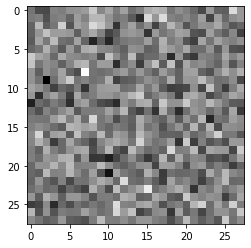

In [14]:
plt.imshow(gen_imgs[0], cmap='gray')

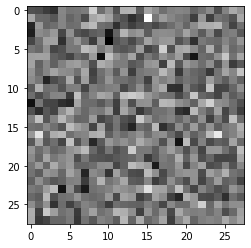

In [15]:
plt.imshow(gen_imgs[1], cmap='gray')

In [16]:
G.to(device)
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Discriminator Training

In [17]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=3e-4)

In [18]:
def train_discriminator(imgs):
    # Create the Labels which are later used as input for the loss func
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    z = torch.randn(batch_size, latent_size).to(device)

    # Loss for real images
    outputs = D(imgs)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    fake_images = G(z)
    outputs  = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine Losses
    d_loss= d_loss_fake + d_loss_real
    # reset gradients
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    # Compute grad
    d_loss.backward()
    # Update parameteres
    d_optimizer.step()

    return d_loss, real_score, fake_score


## Generator Training

In [19]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=3e-4)

In [20]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images),labels)

    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

In [21]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

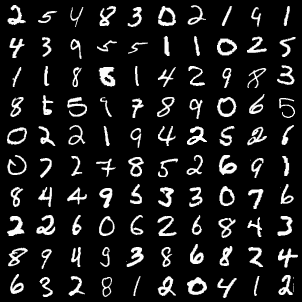

In [22]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


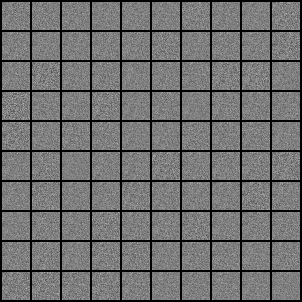

In [23]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [24]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load a batch
        images = images.reshape(batch_size,-1).to(device)

        # Train
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Sample and save imgs
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0504, g_loss: 4.4997, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0242, g_loss: 5.4914, D(x): 0.99, D(G(z)): 0.02
Epoch [0/300], Step [600/600], d_loss: 0.0942, g_loss: 6.1872, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.4808, g_loss: 6.9428, D(x): 0.89, D(G(z)): 0.11
Epoch [1/300], Step [400/600], d_loss: 0.4383, g_loss: 4.2999, D(x): 0.87, D(G(z)): 0.12
Epoch [1/300], Step [600/600], d_loss: 0.1877, g_loss: 6.9134, D(x): 0.97, D(G(z)): 0.11
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.2114, g_loss: 2.8606, D(x): 0.81, D(G(z)): 0.39
Epoch [2/300], Step [400/600], d_loss: 0.4351, g_loss: 3.7377, D(x): 0.85, D(G(z)): 0.10
Epoch [2/300], Step [600/600], d_loss: 0.1736, g_loss: 5.4890, D(x): 0.92, D(G(z)): 0.04
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.9724, g_loss: 2.6009, D(x): 0.73, D(G(z)): 0.30
Epoch [3/300], Step [400/6

In [26]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

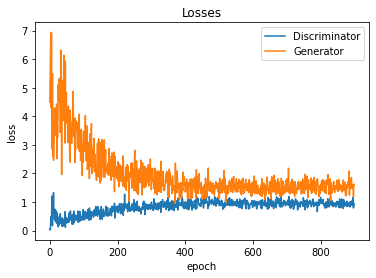

In [27]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

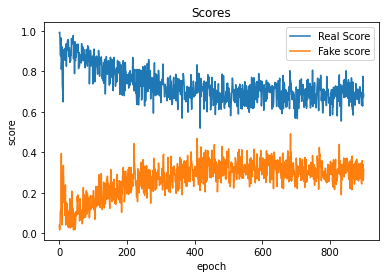

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');